PPCA lavora con più variabili osservabili anzichè una sola

In [1]:
import time

start = time.time()

In [2]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import aesara.tensor as at
import arviz as az
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from scipy import stats
import scipy
import pandas as pd

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
scaler = StandardScaler()

In [4]:
#data = np.load('prova.npy', allow_pickle=True).item()

# extract data social anxiety

In [5]:
#csv_ = '/Users/marcoghezzi/PycharmProjects/pythonProject/osfstorage-archive/behavior/LookAtMe_045.csv'
csv_ = '/home/paolo/matteo/matteo/unimi/tesi_master/code/osfstorage-archive/behavior/LookAtMe_045.csv'
global_data = pd.read_csv(csv_, sep='\t')
y = np.array(list([int(d>2) for d in global_data['rating']]))
e_labels = y[:,np.newaxis]  # rating > 2

In [6]:
print(len(e_labels))

160


In [7]:
num_trials_to_remove = 16

In [8]:
e_labels= e_labels[num_trials_to_remove:]

In [9]:
print(len(e_labels))

144


In [10]:
N_e = e_labels.shape[0]
D_e = e_labels.shape[1]
print(N_e,D_e)

144 1


## test with new data

In [11]:
from deepemogp import feature_extractor
from deepemogp.signal import physio as physio
from deepemogp import datasets as datasets
from deepemogp.signal import behavior as behavior
from deepemogp.signal.physio import ecg
# from: https://github.com/SheffieldML/GPy
#import GPy
# from: https://github.com/SheffieldML/PyDeepGP
#import deepgp

import pandas as pd
import numpy as np

show = False
# definition of the feature extractors to be used later
f2 = feature_extractor.FE('wavelet', window=(2, 1))
f3 = feature_extractor.FE('mean', window=(1,0))

# definition of the physiological signals to be extracted
eda_ = physio.EDA(f2)
hr_ = physio.HR(f2)
pupil_ = behavior.PUPIL(f3)

# definition of the emotional annotation to be extracted
#va = annotation.VA('valence', f3)
#ar = annotation.VA('arousal', f3)
# extraction of the desired data from the dataset
d = datasets.FEAR(signals={hr_,pupil_,eda_}, subjects={'45'})

for s in d.signals:
    # preprocess ...
    if s.name =='EDA':
        s.preprocess(show=show,new_fps=500)
        s.feature_ext.extract_feat(s,show=show)
    else:
        if s.name == 'HR':
            list_hr_test = s.raw[0]['data']
            s.preprocess(show=show, useneurokit=True)
            s.feature_ext.extract_feat(s,show=show)

        else:
            s.feature_ext.extract_feat_without_preprocess(s, show=show)

    #add feature extraction for eda before preprocessing

    # ... and extract features from each signal type


for sig in d.signals:
    if sig.name=='EDA':
        eda_data = sig.features
    if sig.name=='HR':
        hr_data = sig.features
    if sig.name=='PUPIL':
        pupil_data = sig.features

>> Loading EDA for subject 45 and all sessions from dataset FEAR
>> Loading PUPIL for subject 45 and all sessions from dataset FEAR
>> Loading HR for subject 45 and all sessions from dataset FEAR
>> Processing EDA ...
>> Extracting wavelet features from EDA signal, adopting (2, 1) window ...
>> Extracting mean features from PUPIL signal, adopting (1, 0) window ...
>> Processing HR ... using neurokit


/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/neurokit2/epochs/epochs_create.py:205: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for colname, column in epochs[i].select_dtypes(include=["object"]).iteritems():
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/neurokit2/epochs/epochs_create.py:205: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for colname, column in epochs[i].select_dtypes(include=["object"]).iteritems():
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/neurokit2/epochs/epochs_create.py:205: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for colname, column in epochs[i].select_dtypes(include=["object"]).iteritems():
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/n

>> Extracting wavelet features from HR signal, adopting (2, 1) window ...


In [12]:
'''for sig in d.signals:
    print (sig.name)
    print (sig.features)'''

'for sig in d.signals:\n    print (sig.name)\n    print (sig.features)'

In [13]:
list(d.signals)[0].name
d.signals

{<deepemogp.signal.physio.eda.EDA at 0x7fa228333bb0>,
 <deepemogp.signal.behavior.pupil.PUPIL at 0x7fa220fdc4c0>}

In [14]:
np.array(hr_data)

array([[1507.82432239, 1507.82432239, 1507.82432239, ..., 1586.03068697,
        1613.1587688 , 1619.89798969],
       [1507.85637107, 1507.82802011, 1508.46636127, ..., 1478.06965461,
        1395.47520837, 1366.4733097 ],
       [1620.04757606, 1620.00004585, 1619.44095792, ..., 1381.13232251,
        1398.42285198, 1420.22660599],
       ...,
       [1469.66722725, 1469.67133663, 1469.75810463, ..., 1682.85176299,
        1701.05552378, 1703.67041282],
       [1619.65487205, 1619.61171622, 1618.93042939, ..., 1556.47535447,
        1487.88118798, 1466.0223053 ],
       [1703.15260394, 1703.11211732, 1702.7560271 , ..., 1445.25223889,
        1441.56087692, 1441.25889603]])

In [15]:
TRIAL = 160

In [16]:
hr =np.array(hr_data)
np.shape(hr)

(800, 12)

In [17]:
hr = hr.reshape((TRIAL, int(hr.shape[0]/TRIAL*hr.shape[1])))
hr= hr[num_trials_to_remove:]
np.shape(hr)

(144, 60)

In [18]:
pupil = np.array(pupil_data)
pupil = pupil.reshape((TRIAL, int(pupil.shape[0]/TRIAL*pupil.shape[1])))
pupil = pupil[num_trials_to_remove:]
pupil

array([[2.28957916, 2.24162691, 2.25743542, 2.22630423, 2.38095332],
       [2.36868258, 2.39102987, 2.48046672, 2.48633441, 2.82339354],
       [2.67064127, 2.6494933 , 2.83338295, 2.89680195, 2.72045228],
       [2.49301839, 2.57434004, 2.66193764, 2.81392379, 2.87763088],
       [2.61941199, 2.4619111 , 2.36253936, 2.4516599 , 2.6092937 ],
       [2.75129438, 2.49158451, 2.42205538, 2.7312255 , 2.98115979],
       [2.45358019, 2.65098693, 2.53686958, 2.57464519, 2.71543636],
       [2.45708751, 2.45795594, 2.67679892, 2.75354411, 2.99927171],
       [2.56581758, 2.56581015, 2.77308503, 2.76511497, 2.93824643],
       [2.38373017, 2.57278398, 2.5560109 , 2.6140381 , 3.01098913],
       [2.6431281 , 2.73040808, 2.82973441, 2.84983551, 2.94314998],
       [2.50911406, 2.64766184, 2.45722277, 2.4697938 , 2.72666808],
       [2.36618928, 2.42914254, 2.45748706, 2.60572032, 2.97211539],
       [2.54876006, 2.53992921, 2.53885993, 2.59555207, 2.6361397 ],
       [2.64543622, 2.64668624, 2.

In [19]:
eda = np.array(eda_data)
eda = eda.reshape((TRIAL,int(eda.shape[0]/TRIAL*eda.shape[1])))
eda = eda[num_trials_to_remove:]
eda

array([[ 4.95946396e-01,  5.00380905e-01,  4.15766284e-01, ...,
         1.51586866e+01,  1.36052939e+01,  1.22899706e+01],
       [-8.10595181e-01, -8.19055804e-01, -7.13544569e-01, ...,
         1.63096145e+01,  1.60656169e+01,  1.56133868e+01],
       [ 1.59767971e+00,  1.61032834e+00,  1.29374955e+00, ...,
         1.56891940e+01,  1.45877499e+01,  1.35821804e+01],
       ...,
       [-8.87428418e-01, -8.97424247e-01, -8.04640781e-01, ...,
         1.75345145e+01,  2.41071828e+01,  2.83073815e+01],
       [ 1.27413860e+00,  1.28461551e+00,  1.04262039e+00, ...,
         3.05011220e+01,  3.90704780e+01,  4.29526697e+01],
       [-1.25129379e-02, -1.24530688e-02, -5.70494938e-03, ...,
         2.95990803e+01,  4.42385068e+01,  5.23625619e+01]])

## end test

prendo un'implementazione di sppca e la applico al nostro caso

different types of observable data

1) gaze
2) fisio
    2.1) heart rate variability
    2.2) eda phasic value
3) social anxiety
4) aspettativa del dolore

In [20]:

'''social_anx = data['social anxiety'][:,np.newaxis]
pain_exp = data['pain expectation'][:,np.newaxis]'''


"social_anx = data['social anxiety'][:,np.newaxis]\npain_exp = data['pain expectation'][:,np.newaxis]"

In [21]:
print(pupil.shape)
print(hr.shape)
print(eda.shape)

(144, 5)
(144, 60)
(144, 60)


In [22]:
N_pupil = pupil.shape[0]
D_pupil = pupil.shape[1]

N_hr = hr.shape[0]
D_hr = hr.shape[1]

N_eda = eda.shape[0]
D_eda = eda.shape[1]
K = 5

print(N_pupil,D_pupil)
print(N_hr,D_hr)
print(N_eda,D_eda)
print(N_e, D_e)

144 5
144 60
144 60
144 1


In [23]:
with pm.Model() as sPPCA:
    #dati osservabili
    hr_data = pm.MutableData("hr_data", hr.T)
    #hr_data = pm.Minibatch(hr.T,batch_size=60)

    pupil_data = pm.MutableData("pupil_data", pupil.T)
    #pupil_data = pm.Minibatch(pupil.T,batch_size=5)

    eda_data = pm.MutableData("eda_data", eda.T)
    #eda_data = pm.Minibatch(eda.T,batch_size=60)

    e_data = pm.ConstantData("e_data", e_labels.T)

    #matrici pesi
    Whr = pm.Normal('Whr', mu=at.zeros([D_hr, K]), sigma=2.0 * at.ones([D_hr, K]), shape=[D_hr, K])
    Wpupil = pm.Normal('Wpupil', mu=at.zeros([D_pupil, K]), sigma=2.0 * at.ones([D_pupil, K]), shape=[D_pupil, K])

    Weda = pm.Normal('Weda', mu=at.zeros([D_eda, K]), sigma=2.0 * at.ones([D_eda, K]), shape=[D_eda, K])

    #weight matrix for pain expectation.
    #check mu,sigma,shape
    We = pm.Normal('W_e', mu=at.zeros([D_e, K]), sigma=2.0 * at.ones([D_e,K]), shape=[D_e, K])

    #latent space
    c = pm.Normal('c', mu=at.zeros([N_hr,K]), sigma=at.ones([N_hr,K]), shape=[N_hr,K])

    # dati dell'hrv interpretati come una gaussiana
    x_hr = pm.Normal('x_hr', mu=Whr.dot(c.T), sigma=at.ones([D_hr,N_hr]) ,shape=[D_hr, N_hr], observed=hr_data)
    # dati della dilatazione pupille interpretati come una gaussiana
    x_pupil = pm.Normal('x_pupil', mu=Wpupil.dot(c.T), sigma=at.ones([D_pupil, N_pupil]), shape=[D_pupil, N_pupil], observed=pupil_data)
    #eda
    x_eda = pm.Normal('x_eda',mu=Weda.dot(c.T),sigma= at.ones([D_eda,N_pupil]), shape=[D_eda,N_eda], observed=eda_data)

    # pain expectation. ciò che dovremmo inferire dato c
    # due strade: binary o multiclass (1-4)
    # p = probability of success?
    x_e = pm.Bernoulli('x_e' , p=pm.math.sigmoid(We.dot(c.T)) , shape =[D_e, N_e], observed=e_data)

    #x_hr = pm.Bernoulli('x_hr', p=pm.math.sigmoid(Whr.dot(c.T)), shape=[D_hr, N_hr], observed=hr_data)
    #x_eda = pm.Bernoulli('x_eda', p=pm.math.sigmoid(Weda.dot(c.T)), shape=[D_eda, N_eda], observed=eda_data)

In [24]:
gv = pm.model_to_graphviz(sPPCA)
gv.view()

'.gv.pdf'

In [25]:
sPPCA.free_RVs

[Whr ~ N(f(), f()),
 Wpupil ~ N(f(), f()),
 Weda ~ N(f(), f()),
 W_e ~ N(f(), f()),
 c ~ N(f(), f())]

In [26]:
with sPPCA:
    approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    trace = approx.sample(500)

qt5ct: using qt5ct plugin
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/16/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/16@2x/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/16/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/16@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/22/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/22@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/24/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/24@2x/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/24/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/24@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/32/"
Invalid Context= "Apps" line

Finished [100%]: Average Loss = 4.4201e+07


In [27]:
'''
with sPPCA:
    trace = pm.sample(1000,init='advi+adapt_diag',chains=1,target_accept=0.95)
'''


"\nwith sPPCA:\n    trace = pm.sample(1000,init='advi+adapt_diag',chains=1,target_accept=0.95)\n"

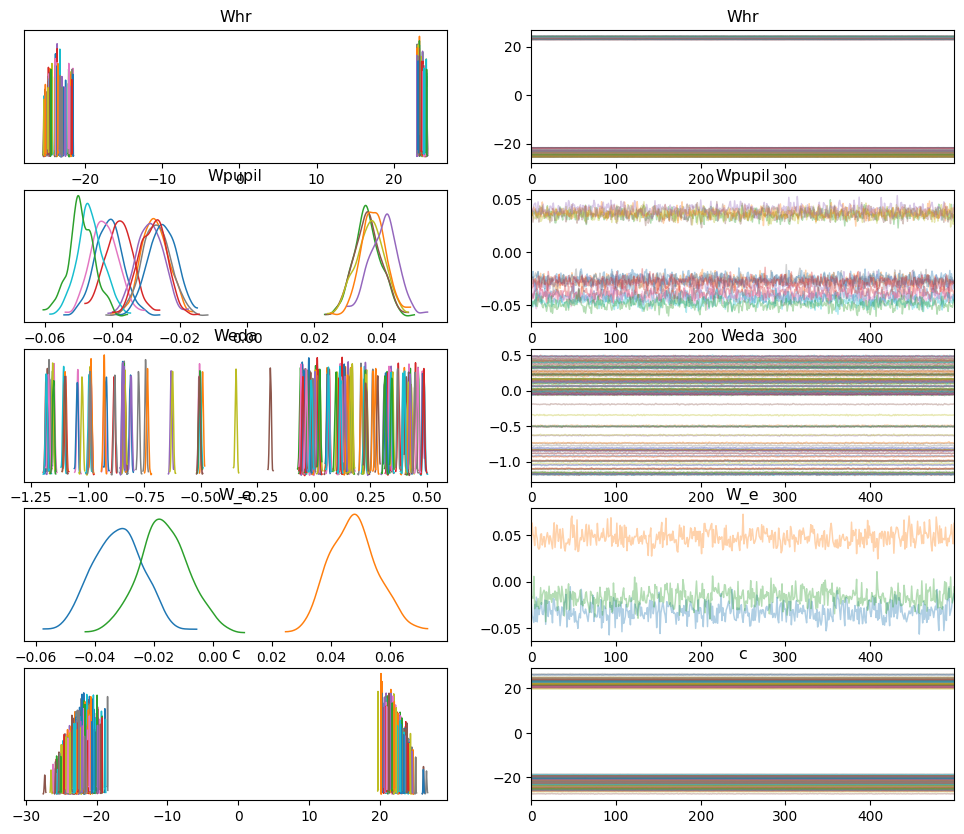

In [28]:
#az.plot_posterior(mean_field.sample(1000), color="LightSeaGreen")
az.plot_trace(trace)
plt.show()

In [29]:
with sPPCA:
    # update values of predictors:
    pm.set_data({"pupil_data": pupil,"hr_data":hr,"eda_data":eda})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123)

Sampling: [x_e, x_eda, x_hr, x_pupil]


In [30]:
e_pred = posterior_predictive.posterior_predictive["x_e"]

In [31]:
e_pred_mode = np.squeeze(stats.mode(e_pred[0], keepdims=False)[0])[:,np.newaxis]

In [32]:
e_pred_mode

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [33]:
e_labels

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
    

In [34]:
train_accuracy_exp = accuracy_score(e_labels, e_pred_mode)
print('\n\tTrain Accuracy Pain Expectation: ' + str(train_accuracy_exp))
print(' ')


	Train Accuracy Pain Expectation: 0.6527777777777778
 


In [35]:
end = time.time()

millis=(end-start) * 10**3
seconds=(millis/1000)%60
seconds = int(seconds)
minutes=(millis/(1000*60))%60
minutes = int(minutes)
hours=(millis/(1000*60*60))%24

print ("time execution hours min secs \n %d:%d:%d" % (hours, minutes, seconds))

 time execution hours min secs 
 0:3:16


--------------------------------------------------------------------------------------------

In [36]:
hr_pred_mean = (stats.median_abs_deviation(hr_pred[0]))[0]
hr_pred_mean

NameError: name 'hr_pred' is not defined

In [ ]:
hr[0]

In [ ]:
#hr_pred_mode= pd.Series([0.006,0.01,0.02,0.003])

hr and hr_pred_mode devono avere same shape

In [ ]:
train_accuracy_hr = (np.subtract(hr[0], hr_pred_mean))
print('\n\t avg distance hr: \n' + str(train_accuracy_hr))
#print(' ')

In [ ]:
with sPPCA:
    # update values of predictors:
    pm.set_data({"hr_data": hr})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123)
    gaze_pred = posterior_predictive.posterior_predictive["x_gaze"]

In [ ]:
gaze_pred

In [ ]:
gaze_pred_mean = np.mean(gaze_pred, axis=0).T.reshape(-1)
gaze_true = pupil.reshape(-1)
reconstructed_r2 = metrics.r2_score(gaze_true, gaze_pred_mean)

print('\n\tReconstructed X R2 score: ' + str(reconstructed_r2))

In [ ]:
import deepemogp.feature_extractor as feature_extractor

In [ ]:
f = feature_extractor.FE('wavelet', window=(8,6), params={'w_mother':'db3','w_maxlev':1})

In [ ]:
x = [3, 7, 1, 1, -2, 5, 4, 6]

In [ ]:
f.apply(x)